Functions

In [1]:
def frac_overlap(df, c, th, reps):
    den = len(df)
    point = sum(df[c]>=th)
    boots = [sum(df.sample(n=den, replace=True)[c]>=th) for r in range(reps)]
    high = np.percentile(boots, 97.5)
    low = np.percentile(boots, 2.5)
    ser = pd.Series([low/den, point/den, high/den, den])
    ser.index = ["low", "point", "high", "den"]
    return ser

Read data

In [15]:
l = []
species = ["corn", "rattle"]
spots = ["hotspots", "coldspots"]
for sp in species:
    for s in spots:
        df = pd.read_csv("../misc_files/{}.{}.annotated.bed".format(sp, s),
                         sep="\t", header=None)
        df.columns = ["scaf", "start", "end", "heat", "spot_id", "nature", "cpgi1", "cpgi2", "lift_bp", "dist2sp"]
        df["species"] = sp
        df["spot"] = s
        l.append(df)
d = pd.concat(l)

Classify distance to CpG islands

In [16]:
th = 1e3
far_th = 10e3
d["cpgi1_bool"] = ["close" if distance<=th else "far" if distance>far_th else "intermediate" for distance in d.cpgi1]
d["cpgi2_bool"] = ["close" if distance<=th else "far" if distance>far_th else "intermediate" for distance in d.cpgi2]

Heat depending on shared

In [20]:
hot = d[d.nature.str.contains("hotspots")]
hot = hot[hot.dist2sp.between(0,1e10)].reset_index()

In [24]:
hot["shared"] = hot.lift_bp>1.5e3

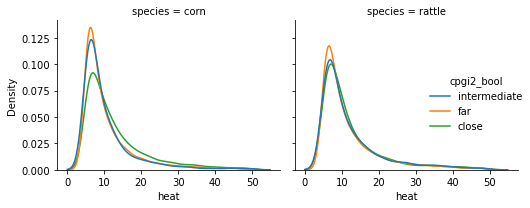

In [51]:
sns.displot(data=hot[hot.heat.between(5,50)], col="species", x="heat", 
            hue="cpgi2_bool", kind="kde", alpha=0.8,
            common_norm=False, 
            aspect=1, height=3)
plt.tight_layout()
#plt.savefig("pdfs/heat_by_shared.pdf")

How many hotspots at CpG islands?

In [327]:
max_heats = list(range(5, 50, 1))
dist = "cpgi2"
th = 1

In [350]:
subd = d#[(d.lift_bp<10e3) & (d.heat<100)]
res_frac_l = []

for nat,df in subd.groupby("nature"):
    for h in max_heats:
        for th in np.linspace(0, 5000, 11):
            sdf = df[df.heat>=h]
            frac = sum(sdf[dist]<=th)/len(sdf)
            sp = sdf.nature.values[0].split(".")[0]
            res_frac_l.append([nat, frac, h, len(sdf), th, sp])

res_frac = pd.DataFrame(res_frac_l)
res_frac.columns = ["nature", "frac", "max_heat", "l", "close_dist", "species"]

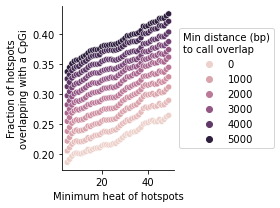

In [354]:
f,ax = plt.subplots(figsize=[4,3])

sns.scatterplot(data=res_frac[res_frac.nature.str.contains("rattle.hot")], 
                x="max_heat", y="frac", 
                hue="close_dist")
#ax.set_ylim(bottom=0)
ax.set_xlabel("Minimum heat of hotspots")
ax.set_ylabel("Fraction of hotspots\noverlapping with a CpGi")
ax.legend(title="Min distance (bp)\nto call overlap",loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.tight_layout()

Overlap between spots depending on nature

In [8]:
dist = "cpgi2_bool"
ss = d[(d.lift_bp<10e3) & (d.heat<200) & (d.heat>=10)]
print(len(d), len(ss))
o = ss.dropna().groupby([dist, "nature"]).apply(lambda x: frac_overlap(x, "lift_bp", 2500, reps=100)).reset_index()
#o = d[d.lift_bp<10e3].dropna().groupby([dist, "nature"]).apply(lambda x: frac_overlap(x, "dist2sp", 1e3, reps=100)).reset_index()

o["species"] = [n.split(".")[0] for n in o.nature]
o["spot"] = [n.split(".")[1] for n in o.nature]

63258 25450


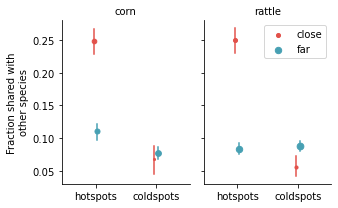

In [14]:
x_order = ["hotspots", "coldspots"]
hue_order = ["close", "far"]

g = sns.FacetGrid(data=o, col="species", height=3, aspect=0.8)

seen = []
colors = [sns.color_palette("Spectral")[0], 
          sns.color_palette("Spectral")[-1]]

dodge = 0.03
xmargin = 0.55

for isp,(sp,ax) in enumerate(g.axes_dict.items()):
    for i,xvar in enumerate(x_order):
        subd = o[(o.species==sp) & 
                 (o.spot==xvar) & 
                 (o[dist].isin(hue_order))]
        for i2,(spot,df) in enumerate(subd.groupby(dist)):            
            color = colors[i2] #"C{}".format(i2)
            x = i - dodge if i2==0 else i + dodge
            xp = i - dodge*2.5 if i2==0 else i + dodge*2.5
            ax.scatter(x, df.point, 
                       color=color, s=df.den/100,
                       label=spot if spot not in seen else "")
            ax.plot([x,x], [df.low, df.high], color=color)
            num = "{:.1f}".format(int(df.point*df.den)/1000)
            den = "{:.1f}".format(int(df.den)/1000)
            #ax.annotate(r"$\frac{{{n}}}{{{d}}}$".format(n=num,d=den), 
            #            xy=(xp, df.point),
            #            ha="right" if spot=="close" else "left",
            #            va="center", 
            #            fontsize=11,
            #            c=color)
            if isp!=0:
                seen.append(spot)

    if isp!=0:
        ax.legend()
    
    ax.set_title(sp, fontsize=10)
    ax.set_xticks([0,1])
    ax.set_xticklabels(x_order)
    ax.set_ylabel("Fraction shared with\nother species" if isp==0 else "")
    ax.set_xlim([-xmargin,1+xmargin])

g.tight_layout()
g.savefig("pdfs/hotspots_sharing_overlap_nolabs.pdf")